# Adult Census Income Prediction

## Project Goal

The goal here is to predict whether someone makes more than $50,000/year using census data.  
this notebook walks through the whole pipeline: loading, cleaning, exploring, feature engineering, splitting, scaling, modeling, and evaluation.  
we use the custom courselib library together with newly created custom functions and try to show clear visuals and explanations at each step.

## Pipeline Overview

1.  **Load & Clean Data**
2.  **Exploratory Data Analysis (EDA)**
3.  **Feature Engineering & Preprocessing**
    -   3.1 Category Merging
    -   3.2 Data Splitting into train and test
    -   3.3 Feature Encoding strategies (target, ordinal, one-hot, frequency) 
    -   3.4 Feature Correlations
    -   3.5 Data Splitting into features and target
    -   3.5 Scaling Numerical Features
4.  **Model Training**
    -   4.1 Base model
    -   4.2 Comparing different regularized models
5.  **Hyperparameter Tuning**
6.  **Model Evaluation & Comparison**

## 1 Load & Clean Data

In [252]:
# Enable autoreloading of imported modules
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Add the repo root to access the courselib
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
courselib_path = os.path.join(repo_root, "AppliedML", "courselib")
if courselib_path not in sys.path:
    sys.path.insert(0, courselib_path)
    print(f"{courselib_path} added to sys.path.")
else:
    print("Courselib path already in sys.path.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Courselib path already in sys.path.


As this project is supposed to integrate well with the courselib, we have downloaded the current GitHub Repo up to week 11 and our code will be integrated within courselib libraries.

In [253]:
from utils.loaders import load_uciadult

# ensure the data directory exists / else create it
os.makedirs('data', exist_ok=True)

# get the data
df = load_uciadult()

Dataset loaded successfully. Shape: (48841, 15)


In [254]:
# check for missing values
df.isnull().sum()

age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
income               0
dtype: int64

1.  **Handle Duplicates**: We remove any duplicate rows from the dataset.
2.  **Handle Missing Values**: Instead of dropping rows with missing values, we treat them as the separate category  `Missing` in categorical columns. This allows us to preserve potentially useful information — for example, individuals with unknown workclass or occupation might share certain income patterns. This approach is especially appropriate for categorical variables, where missingness itself may contain information. Fortunately, this data set does not contain other missing data.


In [255]:
from utils.preprocessing import preprocess_data

# preprocessing of  the data
df = preprocess_data(df)

52 duplicate observations in the dataset were removed.


In [256]:
# first glimpse into the data set
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


# 2. Exploratory Data Analysis (EDA)

In [257]:
# basic info about the data set 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48789 entries, 0 to 48840
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             48789 non-null  int64   
 1   workclass       48789 non-null  category
 2   fnlwgt          48789 non-null  int64   
 3   education       48789 non-null  category
 4   education-num   48789 non-null  int64   
 5   marital-status  48789 non-null  category
 6   occupation      48789 non-null  category
 7   relationship    48789 non-null  category
 8   race            48789 non-null  category
 9   sex             48789 non-null  category
 10  capital-gain    48789 non-null  int64   
 11  capital-loss    48789 non-null  int64   
 12  hours-per-week  48789 non-null  int64   
 13  native-country  48789 non-null  category
 14  income          48789 non-null  int64   
dtypes: category(8), int64(7)
memory usage: 3.4 MB


In [258]:
# summary stats about the variables
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income
count,48789.000000,4.878900e+04,48789.000000,48789.000000,48789.000000,48789.000000,48789.000000
mean,38.653078,1.896682e+05,10.078870,1080.239829,87.597368,40.425895,0.239419
std,13.708494,1.056182e+05,2.570034,7455.980728,403.213066,12.392856,0.426733
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.175550e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.781370e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.376080e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


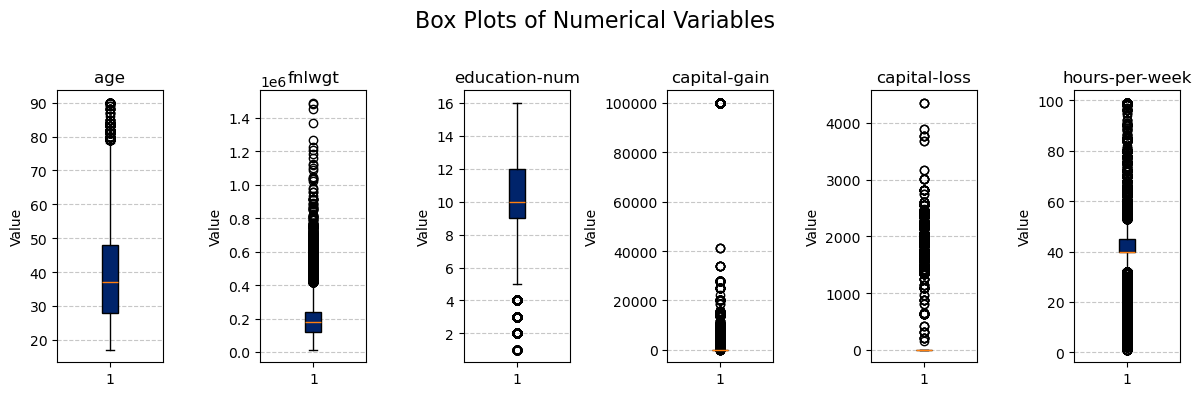

In [259]:
# boxplots of the numerical cols 
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
if 'income' in numerical_cols:
    numerical_cols.remove('income')

# grid of box plots
fig, axes = plt.subplots(nrows=1, ncols=len(numerical_cols), figsize=(12, 4))
fig.suptitle('Box Plots of Numerical Variables', fontsize=16)

for i, col in enumerate(numerical_cols):
    ax = axes[i]
    ax.boxplot(df[col], patch_artist=True, boxprops=dict(facecolor='#00246B'))
    ax.set_title(col, fontsize=12)
    ax.set_ylabel('Value')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

- High Skewness: `fnlwgt`, `capital-gain`, and `capital-loss` are heavily right-skewed. For `capital-gain`, and `capital-loss`, the majority of values are zero, with a few very large outliers. This indicates that these events are rare but have a high magnitude when they occur. `fnlwgt`is dropped as that variable is difficult to interpret. (It indicates how many people in the population a particular record represents and is therefore not an individual attribute and also highly skewed with high variance.)
- Moderate Outliers: age and hours-per-week also show outliers but have more symmetric distributions.

In [260]:
from utils.preprocessing import log_transform

# skewed columns and apply log transformation to have them on a more similar scale
skewed_cols = ['capital-gain', 'capital-loss']
df = log_transform(df, skewed_cols)
df.drop('fnlwgt', axis=1, inplace=True) # fnlwgt is difficult to interpret

The following chart shows a class imbalance in the data: approximately 76% of individuals earn <=50K (low-earners = 0) while only 24% earn >50K (high-earners = 1). A model trained on this data might become biased towards predicting the majority class. Standard accuracy can be a misleading metric; a naive model that always predicts <=50K would be ~76% accurate but completely useless.

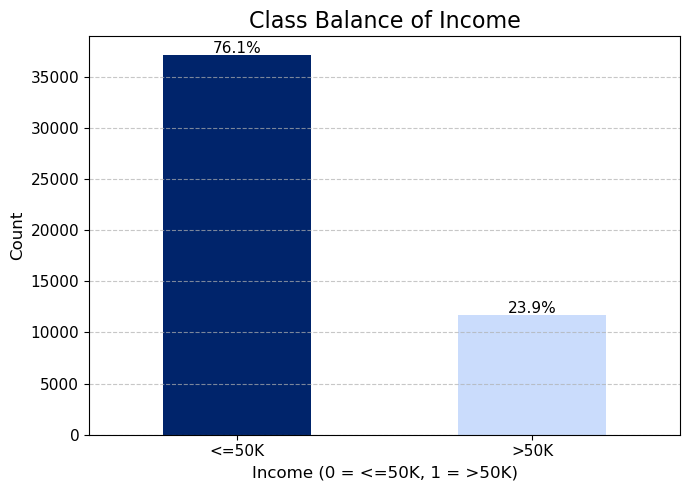

In [261]:
# distribution of the target variable
plt.figure(figsize=(7, 5))
bars = df['income'].value_counts().sort_index().plot(
    kind='bar',
    color=['#00246B', '#CADCFC'],
)
plt.title('Class Balance of Income', fontsize=16)
plt.xlabel('Income (0 = <=50K, 1 = >50K)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['<=50K', '>50K'], rotation=0, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
counts = df['income'].value_counts().sort_index()
labels = ['<=50K', '>50K']
for i, count in enumerate(counts):
    pct = count / counts.sum() * 100
    plt.text(i, count + 200, f'{pct:.1f}%', ha='center', fontsize=11)
plt.show()

The age distribution shows that individuals earning over $50K are, on average, older than those earning less. The high-income group's distribution peaks between the late 30s and early 50s, suggesting that income potential increases with age and experience before declining.

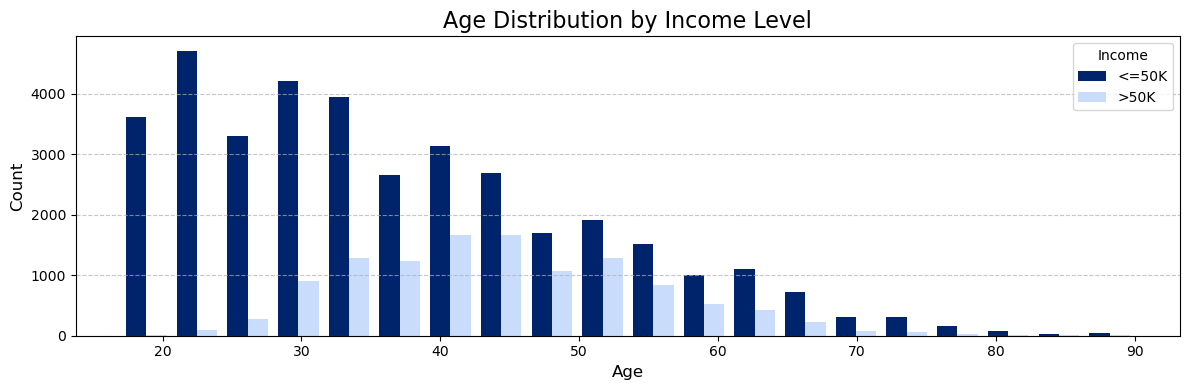

In [262]:
# relationship between income and age
plt.figure(figsize=(12, 4))

# separate data for the two income categories
over50k = df[df['income'] == 0]['age']
below50k = df[df['income'] == 1]['age']

# side-by-side histograms
plt.hist([over50k, below50k], bins=20, color=['#00246B', '#CADCFC'], label=['<=50K', '>50K'])
plt.title('Age Distribution by Income Level', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Income')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

There seems to exist a strong, positive correlation between education and income. The likelihood of earning over $50K increases directly with the level of education, which seems economically reasonable. This clear ordering suggests the use of ordinal encoding for this feature.

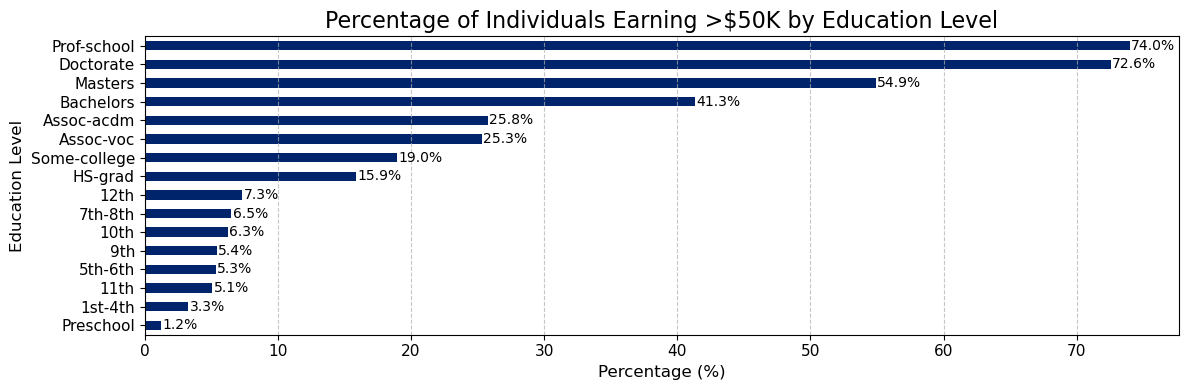

In [263]:
education_income_pct = df.groupby('education', observed=False)['income'].mean().sort_values() * 100

# plot
plt.figure(figsize=(12, 4))
bars = education_income_pct.plot(kind='barh', color='#00246B')
plt.title('Percentage of Individuals Earning >$50K by Education Level', fontsize=16)
plt.xlabel('Percentage (%)', fontsize=12)
plt.ylabel('Education Level', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# percentage labels
for bar in bars.patches:
    plt.text(bar.get_width() + 0.1,
             bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.1f}%',
             va='center',
             ha='left',
             fontsize=10)

plt.tight_layout()
plt.show()

This chart shows the average hours worked per week for each workclass, with bar color indicating the proportion of high-income earners. `Self-emp-inc` stands out with both the highest average hours and the greatest income potential (55.7%). Conversely, categories like `Without-pay` and `Never-worked` show zero high-income potential. The `Missing` category also has a low income potential (10.4%), suggesting that the reason for the missing data might be correlated with lower-paying or non-standard work situations.

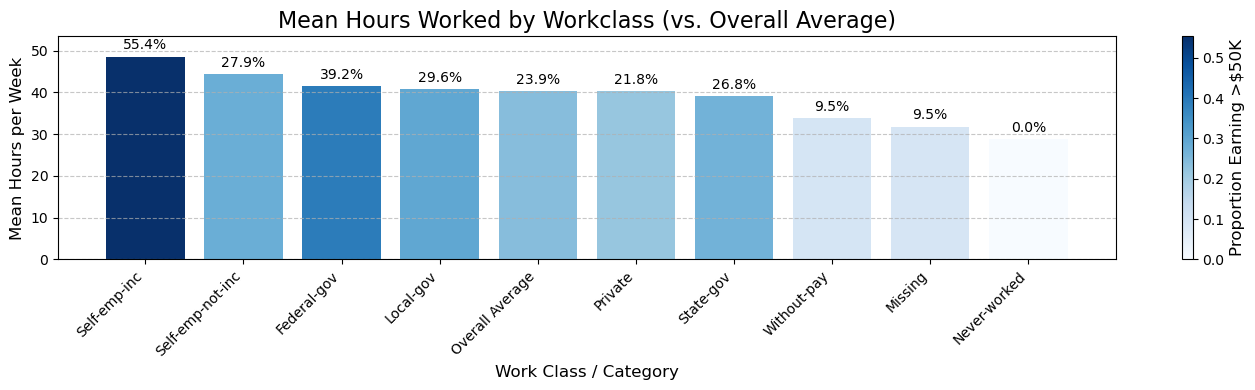

In [264]:
workclass_stats = df.groupby('workclass', observed=False).agg(
    mean_hours=('hours-per-week', 'mean'),
    pct_high_income=('income', 'mean')
)
overall_stats = pd.DataFrame({
    'mean_hours': [df['hours-per-week'].mean()],
    'pct_high_income': [df['income'].mean()]
}, index=['Overall Average'])

# merge workclass stats with overall stats
combined_stats = pd.concat([workclass_stats, overall_stats]).sort_values('mean_hours', ascending=False)

# plot and colormap
fig, ax = plt.subplots(figsize=(14, 4))
cmap = plt.get_cmap('Blues')
norm = plt.Normalize(vmin=combined_stats['pct_high_income'].min(), vmax=combined_stats['pct_high_income'].max())
colors = cmap(norm(combined_stats['pct_high_income'].values))
bars = ax.bar(combined_stats.index, combined_stats['mean_hours'], color=colors)

# color bar for the mean proportion of high-earners
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, pad=0.05)
cbar.set_label('Proportion Earning >$50K', fontsize=12)

# text labels for the proportions
labels = [f'{pct*100:.1f}%' for pct in combined_stats['pct_high_income']]
ax.bar_label(bars, labels=labels, padding=3, fontsize=10, color='black')
ax.set_title('Mean Hours Worked by Workclass (vs. Overall Average)', fontsize=16)
ax.set_xlabel('Work Class / Category', fontsize=12)
ax.set_ylabel('Mean Hours per Week', fontsize=12)
ax.set_ylim(0, combined_stats['mean_hours'].max() * 1.1)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# 3. Feature Engineering


In [265]:
# counts and proportions of every categorical col
categorical_cols_merged = df.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols_merged:
    print(f"--- Feature: {col} ---")
    
    # summary of each group within a col
    summary_df = pd.DataFrame({
        'Count': df[col].value_counts(),
        'Proportion (%)': (df[col].value_counts(normalize=True) * 100).round(2)
    })
    print(summary_df)
    print("_"*40 + "\n")

--- Feature: workclass ---
                  Count  Proportion (%)
workclass                              
Private           33859           69.40
Self-emp-not-inc   3861            7.91
Local-gov          3136            6.43
Missing            2795            5.73
State-gov          1981            4.06
Self-emp-inc       1694            3.47
Federal-gov        1432            2.94
Without-pay          21            0.04
Never-worked         10            0.02
________________________________________

--- Feature: education ---
              Count  Proportion (%)
education                          
HS-grad       15770           32.32
Some-college  10863           22.27
Bachelors      8013           16.42
Masters        2656            5.44
Assoc-voc      2060            4.22
11th           1811            3.71
Assoc-acdm     1601            3.28
10th           1389            2.85
7th-8th         954            1.96
Prof-school     834            1.71
9th             756            1

### 3.1 Category Merging

Before encoding, we will merge some categories to reduce dimensionality and group similar items to simplify features and help the model generalize better. Thus several possible categorical variables are analyzed and discussed.


In [266]:
# to modify the dataset
df = df.copy()

In [267]:
# binary feature for US vs. rest of the world as the dataset is mostly US-related
df['is_from_us'] = df['native-country'].apply(lambda x: 'Yes' if x == 'United-States' else 'No')
df.drop('native-country', axis=1, inplace=True)
print("Value counts for 'is_from_us':\n")
print(df['is_from_us'].value_counts())

Value counts for 'is_from_us':

is_from_us
Yes    43791
No      4998
Name: count, dtype: int64


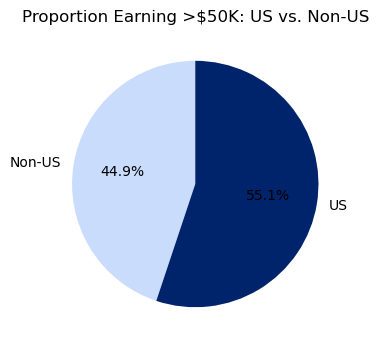

In [268]:
# pie chart for US vs. Non-US
us_vs_nonus = df.groupby('is_from_us')['income'].mean()
labels = ['Non-US', 'US']
plt.figure(figsize=(4, 4))
plt.pie(us_vs_nonus, labels=labels, autopct='%1.1f%%', colors=['#CADCFC', '#00246B'], startangle=90)
plt.title('Proportion Earning >$50K: US vs. Non-US')
plt.show()

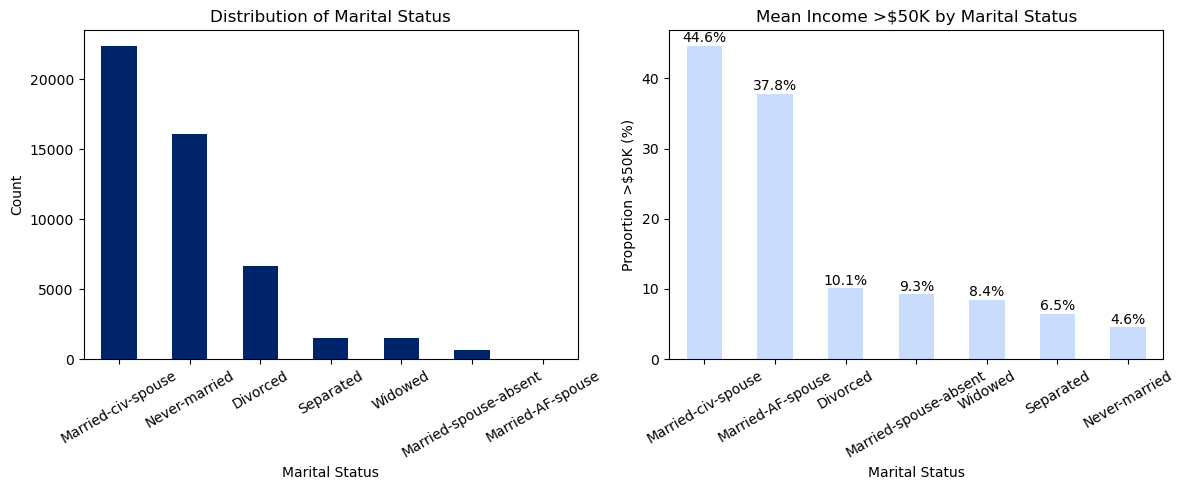

In [269]:
# mean income by marital status

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Count of each marital status
marital_counts = df['marital-status'].value_counts().sort_values(ascending=False)
marital_counts.plot(kind='bar', color='#00246B', ax=axes[0])
axes[0].set_title('Distribution of Marital Status')
axes[0].set_xlabel('Marital Status')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=30)

# Mean income by marital status
marital_income = df.groupby('marital-status', observed=False)['income'].mean().sort_values(ascending=False) * 100
marital_income.plot(kind='bar', color='#CADCFC', ax=axes[1])
axes[1].set_title('Mean Income >$50K by Marital Status')
axes[1].set_xlabel('Marital Status')
axes[1].set_ylabel('Proportion >$50K (%)')
axes[1].tick_params(axis='x', rotation=30)
for i, v in enumerate(marital_income):
    axes[1].text(i, v + 0.5, f"{v:.1f}%", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

The plot suggests that creating a binary feature for married vs. non-married, although we will treat the group Married-spouse-absent, i.e. legally married but not living with spouse (spouse is absent, e.g., separated but not divorced) as non-married.

In [270]:
married_statuses = ['Married-civ-spouse', 'Married-AF-spouse']
df['is_married'] = df['marital-status'].isin(married_statuses).astype(int)
df.drop('marital-status', axis=1, inplace=True)
print("\nValue counts for the new 'is_married' feature:\n")
print(df['is_married'].value_counts())


Value counts for the new 'is_married' feature:

is_married
0    26386
1    22403
Name: count, dtype: int64


In [271]:
# merge husband and wife into spouse in relationship variable to further reduce cardinality for onehot encoding
df['relationship'] = df['relationship'].astype(str).replace({'Husband': 'Spouse', 'Wife': 'Spouse'}).astype('category')

# merge without-pay, never-worked categories into other to further reduce cardinality for onehot encoding
df['workclass'] = df['workclass'].astype(str).replace(['Without-pay', 'Never-worked'], 'Other').astype('category')

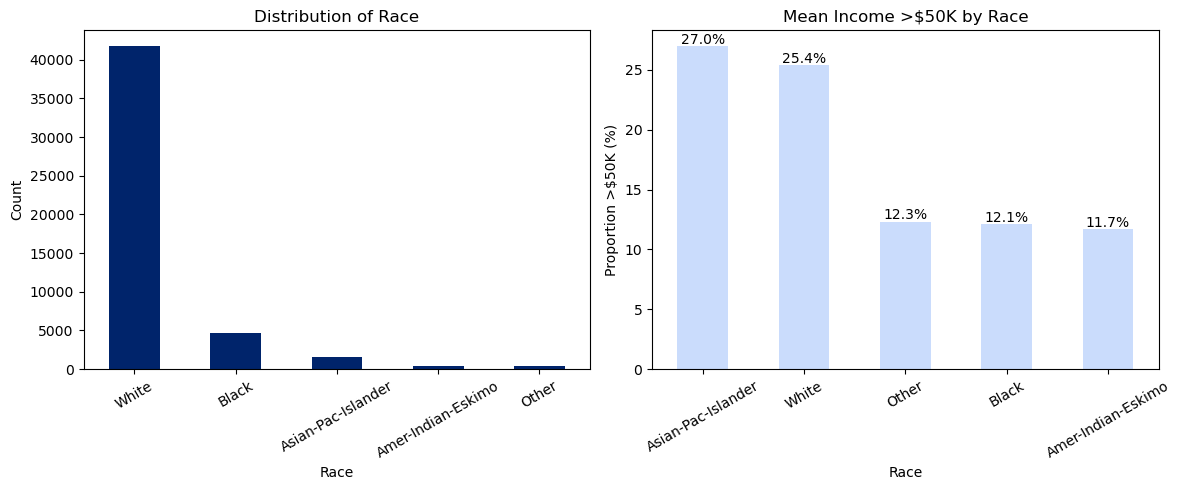

In [272]:
# race distribution and mean income by race
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# count of each race
race_counts = df['race'].value_counts().sort_values(ascending=False)
race_counts.plot(kind='bar', color='#00246B', ax=axes[0])
axes[0].set_title('Distribution of Race')
axes[0].set_xlabel('Race')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=30)

# mean income by race
race_income = df.groupby('race', observed=False)['income'].mean().sort_values(ascending=False) * 100
race_income.plot(kind='bar', color='#CADCFC', ax=axes[1])
axes[1].set_title('Mean Income >$50K by Race')
axes[1].set_xlabel('Race')
axes[1].set_ylabel('Proportion >$50K (%)')
axes[1].tick_params(axis='x', rotation=30)
for i, v in enumerate(race_income):
    axes[1].text(i, v + 0.2, f"{v:.1f}%", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [273]:
# merge Amer-Indian-Eskimo and Other categories into other to further reduce cardinality for onehot encoding
df['race'] = df['race'].astype(str).replace({'Amer-Indian-Eskimo': 'Other'}).astype('category')

The merging of categories in features like race, relationship, and workclass leads to only a small reduction in dimensionality, but is justified because the combined groups are both small and statistically similar in terms of income distribution. This reduces noise and the risk of overfitting, while preserving the main socioeconomic patterns in the data. By merging only where appropriate, we maintain interpretability and model performance without unnecessary simplification.

In [274]:
# number of distinct values in our categorical cols -> what feature encoding strat to use
categorical_vars = ['workclass', 'relationship', 'race', 'sex', 'education', 'occupation', 'is_from_us']

for var in categorical_vars:
    if var in df.columns:
        unique_vals = df[var].unique()
        print(f"{var}: {len(unique_vals)} unique values:\n {list(unique_vals)}\n")

workclass: 8 unique values:
 ['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov', 'Local-gov', 'Missing', 'Self-emp-inc', 'Other']

relationship: 5 unique values:
 ['Not-in-family', 'Spouse', 'Own-child', 'Unmarried', 'Other-relative']

race: 4 unique values:
 ['White', 'Black', 'Asian-Pac-Islander', 'Other']

sex: 2 unique values:
 ['Male', 'Female']

education: 16 unique values:
 ['Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college', 'Assoc-acdm', 'Assoc-voc', '7th-8th', 'Doctorate', 'Prof-school', '5th-6th', '10th', '1st-4th', 'Preschool', '12th']

occupation: 15 unique values:
 ['Adm-clerical', 'Exec-managerial', 'Handlers-cleaners', 'Prof-specialty', 'Other-service', 'Sales', 'Craft-repair', 'Transport-moving', 'Farming-fishing', 'Machine-op-inspct', 'Tech-support', 'Missing', 'Protective-serv', 'Armed-Forces', 'Priv-house-serv']

is_from_us: 2 unique values:
 ['Yes', 'No']



### 3.2 Data Splitting

To prevent data leakage, we must split the data into training and testing sets *before* any encoding or scaling. Previously, this mistake lead to artificially good performance on the validation set. All fitting steps (like for encoders and scalers) will be performed on the training set only and then applied to both the training and test sets.

In [275]:
from utils.splits import train_test_split

# returns the full dataset (X, y)
df, train_df, test_df = train_test_split(
    df, 
    training_data_fraction=0.8, 
    class_column_name='income',
    shuffle=True, 
    return_numpy=False # dataframes instead of numpy arrays
)

print("Train df shape:", train_df.shape)
print("Test df shape:", test_df.shape)

Train df shape: (39031, 14)
Test df shape: (9758, 14)


### 3.3 Feature Encoding strategies

Feature encoding transforms categorical variables into numerical values for machine learning models. We will apply one-hot and ordinal encoding first, followed by a careful application of target encoding to prevent data leakage.

Brief explanation of all the strategies for encoding:

#### 1. One-Hot Encoding

- **Def.:** For a feature with $k$ categories, create $k-1$ binary columns:
  $$
  \text{OneHot}(x = c_j) = [0, \ldots, 1, \ldots, 0] \in \mathbb{R}^{k-1}
  $$
  where the $j$-th position is $1$ if $x = c_j$, else $0$.
- **Example:** If `race` has categories `[White, Black, Asian]` and $x = \text{Black}$, then $\text{OneHot}(x) = [1, 0]$.
- **When/Why:** Use for nominal (unordered) features to avoid implying order. We create $k-1$ columns instead of $k$ to avoid **perfect multicollinearity**, where one feature can be perfectly predicted by the others. This is crucial for linear models. The dropped category  (the most frequent one) becomes the baseline reference.

---

#### 2. Ordinal Encoding

- **Def.:** Map ordered categories to integers:
  $$
  \text{Ordinal}(x = c_j) = j
  $$
  where $j$ is the position in the predefined order.
- **Example:** If `education` order is `[HS-grad, Bachelors, Masters]$ and $x = \text{Bachelors}$, then $\text{Ordinal}(x) = 1$.
- **When/Why:** Use for ordinal features where order matters.

---

#### 3. Target Encoding

- **Def.:** Replace each category with the mean target value:
  $$
  \text{TargetEnc}(x = c_j) = \mathbb{E}[y \mid x = c_j]
  $$
- **Example:** If mean income for `occupation = Tech` is $0.32$, then $\text{TargetEnc}(\text{Tech}) = 0.32$.
- **When/Why:** Use for high-cardinality features; captures target signal but risk of leakage (use cross-validation).

---

#### 4. Frequency Encoding

- **Def.:** Replace each category with its frequency:
  $$
  \text{FreqEnc}(x = c_j) = \frac{\text{count}(x = c_j)}{N}
  $$
  where $N$ is the total number of samples.
- **Example:** If `country = US` appears in $70\%$ of rows, then $\text{FreqEnc}(\text{US}) = 0.7$.
- **When/Why:** Use for high-cardinality features; simple, no leakage.

In [276]:
from utils.preprocessing import encode_and_align_features

# encoding strategies for each column we need to encode
base_encoding = {'one-hot': { 'relationship' : 'Spouse',
                'race' : 'White', # second entry is dropped to avoid multicollinearity
                'sex' : 'Male',
                'is_from_us': 'Yes'},
    'ordinal': {'education': ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th', 'HS-grad',
                               'Some-college', 'Assoc-voc', 'Assoc-acdm', 'Bachelors', 'Masters', 'Prof-school',
                               'Doctorate']},
    'target': {'occupation': 'income'},  # Format: {feature_to_encode: target_column}
    'frequency': ['workclass']
}

train_df_encoded, test_df_encoded, fit_params = encode_and_align_features(
    train_df, test_df, base_encoding, drop_cols=['education-num'])

Train encoded shape: (39031, 18)
Test encoded shape: (9758, 18)


### 3.4 Correlation of Features

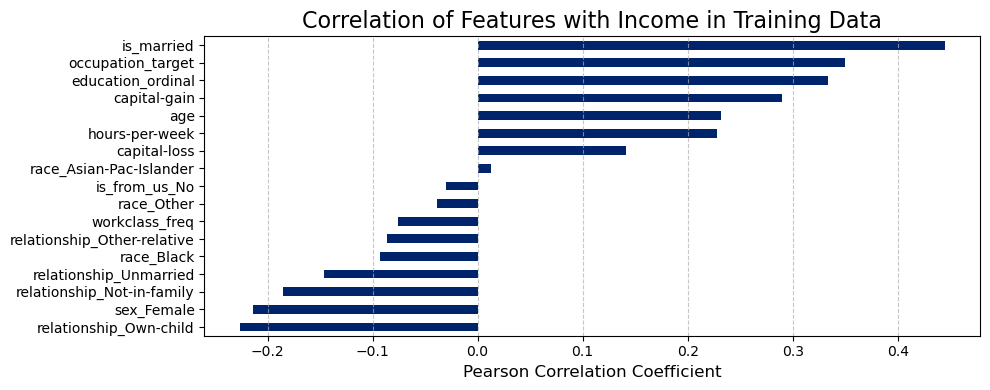

In [277]:
# bar chart of correlations with income
correlation_matrix_encoded = train_df_encoded.corr()
income_correlations = correlation_matrix_encoded['income'].drop('income').sort_values()
plt.figure(figsize=(10, 4))
income_correlations.plot(kind='barh', color='#00246B')
plt.title('Correlation of Features with Income in Training Data', fontsize=16)
plt.xlabel('Pearson Correlation Coefficient', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Interpretation:

*   **Positive Correlation (Features on the right):** Features with a positive bar indicate that as the feature's value increases, the likelihood of having an income `>50K` also increases.
*   **Negative Correlation (Features on the left):** Features with a negative bar indicate that as the feature's value increases, the likelihood of having an income `>50K` decreases.

*   **Strongest Predictors:** `is_married`, `education` (ordinal), `age`, `hours-per-week`, and `capital-gain` show the strongest positive correlations. This aligns with our EDA findings: being married, having higher education, being older, and working more hours are all strongly associated with higher income. The target-encoded `occupation` feature is also a very strong predictor by design.

*   **Negative Predictors:** The strongest negative correlations come from one-hot encoded features like `relationship_Own-child` and `relationship_Not-in-family`. This indicates that individuals in these relationship categories are significantly less likely to have high income.


The dropped variables are the silent baseline against which all the other one-hot encoded columns from that same feature are measured. Their relationships are not directly visible in the matrix, but are implicitly defined by the relationships of the columns that are present. The relationship of the dropped `race_White` category is the inverse of the combined effect of the other categories. Because `race_White` is the most frequent category, the other, smaller race categories being negatively correlated with income implies that the large, baseline `race_White` category must have a correlation that is neutral or slightly positive to balance things out.

In [278]:
# strongest 20 absolute correlations
corr_matrix = train_df_encoded.corr(numeric_only=True)
corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
    .rename(columns={'level_0': 'Feature 1', 'level_1': 'Feature 2', 0: 'Correlation'})
)
corr_pairs['AbsCorrelation'] = corr_pairs['Correlation'].abs()
top_corrs = corr_pairs.sort_values('AbsCorrelation', ascending=False).head(20)

print(f"Top 20 strongest (absolute) correlations between features:\n")
print(top_corrs[['Feature 1', 'Feature 2', 'Correlation']].to_string(index=False))

Top 20 strongest (absolute) correlations between features:

                 Feature 1                  Feature 2  Correlation
                is_married relationship_Not-in-family    -0.538131
         education_ordinal          occupation_target     0.484362
                    income                 is_married     0.444745
                is_married                 sex_Female    -0.432103
                       age     relationship_Own-child    -0.432067
                is_married     relationship_Own-child    -0.379016
   race_Asian-Pac-Islander              is_from_us_No     0.365046
                    income          occupation_target     0.349800
                    income          education_ordinal     0.334053
                is_married     relationship_Unmarried    -0.317102
    relationship_Unmarried                 sex_Female     0.315858
                       age                 is_married     0.313552
              capital-gain                     income     0.290247
re

Since we already have 'sex' and the engineered 'is_married' feature, the one-hot encoded 'relationship_*' columns are redundant and can introduce multicollinearity. Dropping all 'relationship_*' columns simplifies the feature set, improves interpretability,
and avoids instability in linear models. Thus, we only keep the variable `is_married` because it is a more interpretable aand makes the model easier to explain.

In [301]:
# drop all one-hot encoded relationship variables to avoid redundancy and multicollinearity
relationship_cols = [col for col in train_df_encoded.columns if col.startswith('relationship_')]
train_df_encoded = train_df_encoded.drop(columns=relationship_cols)
test_df_encoded = test_df_encoded.drop(columns=relationship_cols)

### 3.5 Data Splitting into features and target

In [302]:
from utils.splits import split_features_and_target
X_train, y_train, X_test, y_test = split_features_and_target(train_df_encoded, test_df_encoded)

X_train shape: (39031, 13)
X_test shape: (9758, 13)
y_train shape: (39031,)
y_test shape: (9758,)
Train class balance: 0.23947631369936717
Test class balance: 0.23918835827013732


In [303]:
# all columns in the data set
train_df_encoded.columns

Index(['age', 'capital-gain', 'capital-loss', 'hours-per-week', 'income',
       'is_married', 'education_ordinal', 'occupation_target',
       'workclass_freq', 'race_Asian-Pac-Islander', 'race_Black', 'race_Other',
       'sex_Female', 'is_from_us_No'],
      dtype='object')

Text(0.5, 1.0, 'Feature Cardinality Before and After Encoding')

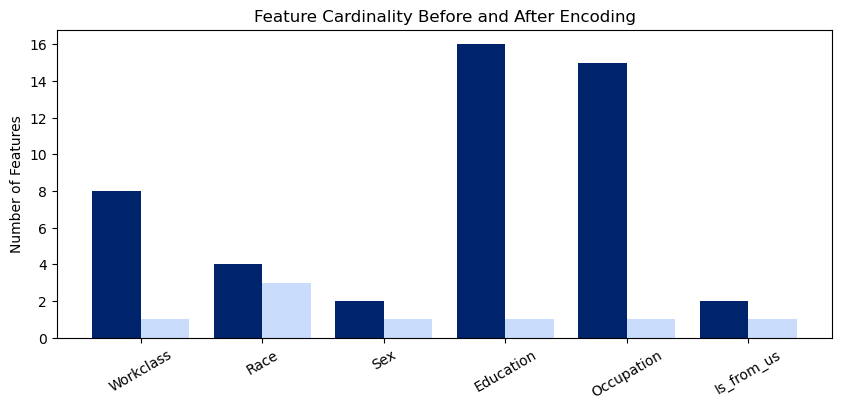

In [305]:
# visualize the dim reduction through feature engineering
cat_cols = ['workclass', 'race', 'sex', 'education', 'occupation', 'is_from_us']
before = [train_df[col].nunique() for col in cat_cols if col in train_df.columns]
after = [train_df_encoded.filter(like=col).shape[1] for col in cat_cols if col in train_df.columns]
x = np.arange(len(before))
plt.figure(figsize=(10,4))
plt.bar(x-0.2, before, width=0.4, label='Before Encoding', color='#00246B')
plt.bar(x+0.2, after, width=0.4, label='After Encoding', color='#CADCFC')
plt.xticks(x, [col.capitalize() for col in cat_cols if col in train_df.columns], rotation=30)
plt.ylabel("Number of Features")
plt.title("Feature Cardinality Before and After Encoding")

### 3.6 Feature Scaling

Before training our models, it's important to scale our numerical features. Of course, it makes no sense to also scale the freshly encoded categorical data, such as the ordinally encoded `education` variable as we would destroy its ordinal structure immediately again.  Models like Logistic Regression are sensitive to the scale of the input data, and scaling can lead to faster convergence and better performance. We will use standardization, where each feature is scaled to have a mean of 0 and a standard deviation of 1.

We will fit the scaler on the training data and use the same scaler to transform the test data. This prevents any information from the test set from leaking into our training process.


In [283]:
from utils.normalization import scale_numerical_features

numerical_cols = [
    'capital-gain', 'capital-loss', 'age', 'hours-per-week',
    'education_ordinal', 'occupation_target', 'workclass_freq'
]

# scale features via normalization
X_train_scaled, X_test_scaled = scale_numerical_features(
    X_train, X_test, train_df_encoded, numerical_cols
)

In [284]:
# check for perfect multicollinearity
rank = np.linalg.matrix_rank(X_train_scaled)
print(f"Feature matrix rank: {rank} / {X_train_scaled.shape[1]} -> no perfect multicollinearity")

Feature matrix rank: 14 / 14 -> no perfect multicollinearity


## 4. Model Training (Logistic Regression)

Predict whether an individual's income exceeds $50,000 per year.

### Models Included:
- **Logistic Regression**: A logistic Regression model for binary classification, optimized using gradient descent.

### Evaluation Metrics:
- **Accuracy**: The proportion of total correct predictions.
  $$ \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN} $$
- **Precision**: The accuracy of positive predictions.
  $$ \text{Precision} = \frac{TP}{TP + FP} $$
- **Recall (Sensitivity)**: The ability of the model to find all the positive samples.
  $$ \text{Recall} = \frac{TP}{TP + FN} $$
- **Training Time**: time taken to train the model to evaluate efficiency.
- **Confusion Matrix**: A table visualizing the counts of TP, TN, FP, and FN.

In [285]:
from models.glm import LogisticRegression
from optimizers import GDOptimizer
from utils.training import ModelTraining
from utils.metrics import accuracy, precision_score, recall_score


# model params
n_features = X_train_scaled.shape[1]
w_init = np.zeros(n_features)
b_init = 0.0
optimizer = GDOptimizer(learning_rate=0.01)

# to save the results from training
results = []

# metrics
metrics_dict = {
    "Accuracy": lambda y_true, y_pred: accuracy(y_pred, y_true, one_hot_encoded_labels=False),
    "Precision": precision_score,
    "Recall": recall_score,
}

# model configurations
model_configs = [
    {
        'model_class': LogisticRegression,
        'model_name': 'Logistic Regression',
        'init_params': {
            'w': w_init.copy(), 
            'b': b_init, 
            'optimizer': GDOptimizer(learning_rate=0.01),
            'penalty': 'none', # 'none', 'ridge', 'lasso'
            'lam': 0.0
        },
        'fit_params': {'num_epochs': 20, 'batch_size': 32}
    }
]

# specify the models to train
models_to_train = []
for config in model_configs:
    model_to_train = ModelTraining(
        model_class=config['model_class'],
        model_name=config['model_name'],
        init_params=config['init_params'],
        metrics_dict=metrics_dict,
        **config['fit_params']
    )
    models_to_train.append(model_to_train)

### 4.1 Base model with detailed evaluation

First train only one model with logistic regression and without cross-validation to analyse that in detail. Then with 5-fold cv for more accurate results.

Model: Logistic Regression


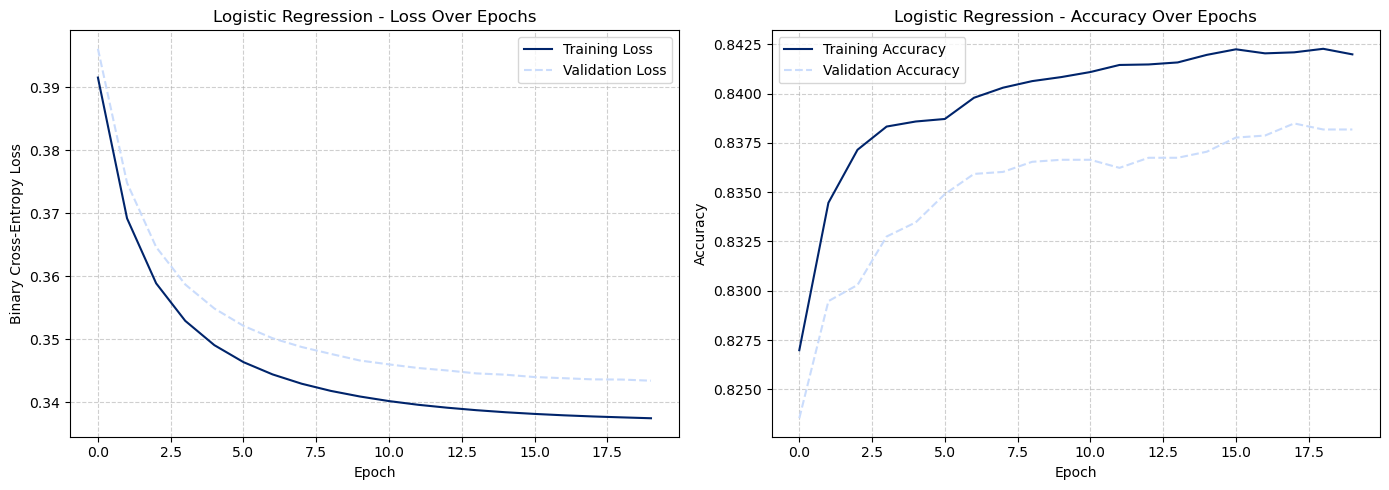

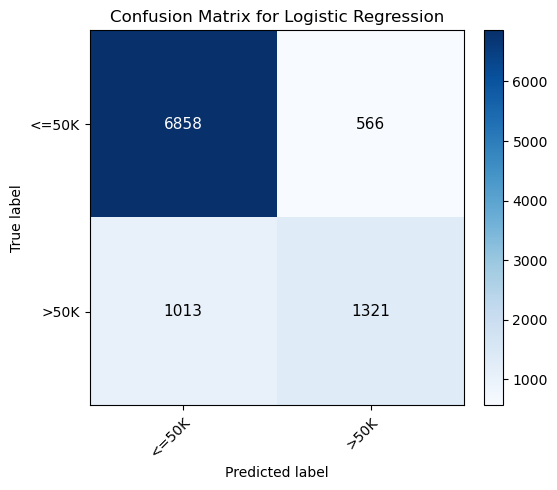

In [286]:
from utils.metrics import plot_training_history

# training process of one model without cv
for model_to_train in models_to_train:
    
    # train the model using the params defined in the dict
    print(100*'=')
    print(f"Model: {model_to_train.model_name}")
    model_to_train.train(X_train_scaled, y_train, X_test_scaled, y_test)
    
    # plot training metrics (accuracy and loss for train/test)
    if model_to_train.history:
        plot_training_history(model_to_train.history, model_to_train.model_name)
        print(100*'=')

    # eval on the test set and store results
    performance = model_to_train.evaluate(X_test_scaled, y_test)
    results.append(performance)
    print("="*60)

In [287]:
# results for the simple training run
results_df = pd.DataFrame(results)
display(results_df)

,Model,Training Time (s),Accuracy,Precision,Recall
0,Logistic Regression,0.852054,83.818405,0.700053,0.565981


### 4.2 Compare different regularized versions of Logistic Regression

In [288]:
from utils.training import ModelTraining

# model configurations
logreg_configs = [
    {
        'model_class': LogisticRegression,
        'model_name': 'Logistic Regression (Base)',
        'init_params': {
            'w': w_init.copy(), 
            'b': b_init, 
            'optimizer': GDOptimizer(learning_rate=0.01),
            'penalty': 'none',
            'lam': 0.0
        },
        'fit_params': {'num_epochs': 20, 'batch_size': 32}
    },
    {
        'model_class': LogisticRegression,
        'model_name': 'Logistic Regression (Weak Ridge)',
        'init_params': {
            'w': w_init.copy(), 
            'b': b_init, 
            'optimizer': GDOptimizer(learning_rate=0.01),
            'penalty': 'ridge',
            'lam': 0.001
        },
        'fit_params': {'num_epochs': 20, 'batch_size': 32}
    },   
    {
        'model_class': LogisticRegression,
        'model_name': 'Logistic Regression (Strong Ridge)',
        'init_params': {
            'w': w_init.copy(), 
            'b': b_init, 
            'optimizer': GDOptimizer(learning_rate=0.01),
            'penalty': 'lasso',
            'lam': 1
        },
        'fit_params': {'num_epochs': 20, 'batch_size': 32}
    },
    {
        'model_class': LogisticRegression,
        'model_name': 'Logistic Regression (Lasso)',
        'init_params': {
            'w': w_init.copy(), 
            'b': b_init, 
            'optimizer': GDOptimizer(learning_rate=0.01),
            'penalty': 'lasso',
            'lam': 0.001
        },
        'fit_params': {'num_epochs': 20, 'batch_size': 32}
    }
]

# specify the logreg models to train
logreg_models_to_train = []
for logreg_config in logreg_configs:
    logreg_model_to_train = ModelTraining(
        model_class=logreg_config['model_class'],
        model_name=logreg_config['model_name'],
        init_params=logreg_config['init_params'],
        metrics_dict=metrics_dict,
        plot_cm=False,
        **logreg_config['fit_params']
    )
    logreg_models_to_train.append(logreg_model_to_train)

In [289]:
# train the models via 5-fold cv now
all_cv_results = []
for logreg_model_to_train in logreg_models_to_train:
    # k-fold cross-validation for current model
    cv_result = logreg_model_to_train.cross_validate(X_train_scaled, y_train, k_folds=5)
    all_cv_results.append(cv_result)
    print("="*60)

CV for Logistic Regression (Base) with 5 folds
CV for Logistic Regression (Weak Ridge) with 5 folds
CV for Logistic Regression (Strong Ridge) with 5 folds
CV for Logistic Regression (Lasso) with 5 folds


In [290]:
# final summary of the cv pf all models tested
cv_results_df = pd.DataFrame(all_cv_results)
display(cv_results_df)

,Model,Mean Accuracy,Std Accuracy,Mean Precision,Std Precision,Mean Recall,Std Recall,Mean Training Time (s),Std Training Time (s)
0,Logistic Regression (Base),84.189490,0.302445,0.716085,0.012567,0.563153,0.008467,0.713259,0.043743
1,Logistic Regression (Weak Ridge),84.168986,0.238973,0.719013,0.016474,0.556391,0.008361,0.735335,0.002830
2,Logistic Regression (Strong Ridge),76.052363,0.471721,0.000000,0.000000,0.000000,0.000000,0.806058,0.054570
3,Logistic Regression (Lasso),84.186938,0.332846,0.718426,0.012677,0.559019,0.009368,0.802917,0.045730


#### Why all those metrics
- Accuracy can be misleading: a model could achieve ~76% accuracy by simply always predicting the majority class (<=50K), making it useless.
- Precision: "Of all the people we predicted would have high income, how many actually did?" Important if the cost of a false positive is high.
- Recall: "Of all the people who actually have high income, how many did we find?" Important if the cost of a false negative is high.
- Confusion Matrix: provides the raw numbers (TP, TN, FP, FN) from which all the other metrics are calculated

## 5 Hyperparameter tuning of those models

In [291]:
# extensive hyperparameter search for logistic regression using a grid of hyperparams - eval via cv
def gridsearch_logistic_regression(X_train, y_train, X_test, y_test, param_grid, cv_folds=None):
    """
    Performs a grid search for Logistic Regression.
    """
    results = []
    
    # parameter grid
    learning_rates = param_grid.get('lr', [0.01])
    epochs_list = param_grid.get('num_epochs', [20])
    penalties = param_grid.get('penalty', ['none'])
    lambdas = param_grid.get('lam', [0.0])

    for lr in learning_rates:
        for num_epochs in epochs_list:
            for penalty in penalties:
                for lam in lambdas:
                    # Skip non-reg if lam is not 0
                    if penalty == 'none' and lam != 0.0:
                        continue
                    # Skip reg if lam is 0
                    if penalty != 'none' and lam == 0.0:
                        continue
                        
                    print(f"Training with lr={lr}, epochs={num_epochs}, penalty='{penalty}', lambda={lam}")

                    # init model with hyperparameters
                    optimizer = GDOptimizer(learning_rate=lr)
                    model = LogisticRegression(
                        w=np.zeros(X_train.shape[1]),
                        b=0.0,
                        optimizer=optimizer,
                        penalty=penalty,
                        lam=lam
                    )
                    
                    # ModelTraining wrapper for training/evaluation
                    trainer = ModelTraining(
                        model_class=LogisticRegression,
                        model_name='Logistic Regression',
                        init_params={'w': model.w, 'b': model.b, 'optimizer': optimizer, 'penalty': penalty, 'lam': lam},
                        metrics_dict=metrics_dict,
                        num_epochs=num_epochs,
                        batch_size=32,
                        plot_cm=False
                    )
                    if cv_folds is not None and cv_folds > 1:
                        # cross-validation mode
                        cv_result = trainer.cross_validate(X_train, y_train, k_folds=cv_folds)
                        # add hyperparams to cv_results
                        cv_result.update({
                            "Learning Rate": lr,
                            "Epochs": num_epochs,
                            "Penalty": penalty,
                            "Lambda": lam
                            })
                        results.append(cv_result)
                    else:
                        # normal training - no cv
                        trainer.train(X_train, y_train)
                        performance = trainer.evaluate(X_test, y_test)
                        results.append({
                            "Learning Rate": lr,
                            "Epochs": num_epochs,
                            "Penalty": penalty,
                            "Lambda": lam,
                            "Accuracy": performance['Accuracy'],
                            "Precision": performance['Precision'],
                            "Recall": performance['Recall']
                        })

    return pd.DataFrame(results)


# grid of hyperparameters
param_grid = {
    'lr': [0.01], #, 0.05, 0.1],
    'num_epochs': [20], #, 50, 100],
    'penalty': ['none', 'ridge', 'lasso'],
    'lam': [0.0, 0.00001],#, 0.1, 1, 10.0]
}


logreg_tuning_results = gridsearch_logistic_regression(
    X_train_scaled, y_train, X_test_scaled, y_test,
    param_grid,
    # cv_folds=5 # optional param as cv takes a lot of time - can be uncommented for faster performance
)

Training with lr=0.01, epochs=20, penalty='none', lambda=0.0
Training with lr=0.01, epochs=20, penalty='ridge', lambda=1e-05
Training with lr=0.01, epochs=20, penalty='lasso', lambda=1e-05


In [292]:
display(logreg_tuning_results)

,Learning Rate,Epochs,Penalty,Lambda,Accuracy,Precision,Recall
0,0.01,20,none,0.00000,83.859397,0.701113,0.566838
1,0.01,20,ridge,0.00001,83.838901,0.701867,0.563839
2,0.01,20,lasso,0.00001,83.859397,0.700475,0.568123


Analysing the best performing model and inspecting its training history.

In [293]:
# find the best model by (mean) accuracy
if "Mean Accuracy" in logreg_tuning_results.columns:
    best_row = logreg_tuning_results.sort_values("Mean Accuracy", ascending=False).iloc[0]
    best_acc = best_row["Mean Accuracy"]
else:
    best_row = logreg_tuning_results.sort_values("Accuracy", ascending=False).iloc[0]
    best_acc = best_row["Accuracy"]

# get the params of the best model
best_penalty = best_row["Penalty"]
best_lam = best_row["Lambda"]
best_lr = best_row["Learning Rate"]
best_epochs = best_row["Epochs"]
print(f"Best model: penalty={best_penalty}, lambda={best_lam}, lr={best_lr}, epochs={best_epochs}")

# retrain on the full training set - no cv here
best_optimizer = GDOptimizer(learning_rate=best_lr)
best_model = LogisticRegression(
    w=np.zeros(X_train_scaled.shape[1]),
    b=0.0,
    optimizer=best_optimizer,
    penalty=best_penalty,
    lam=best_lam
)

Best model: penalty=none, lambda=0.0, lr=0.01, epochs=20


In [294]:
print("Initial weights:", best_model.w)
print("Initial bias:", best_model.b)

Initial weights: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Initial bias: 0.0


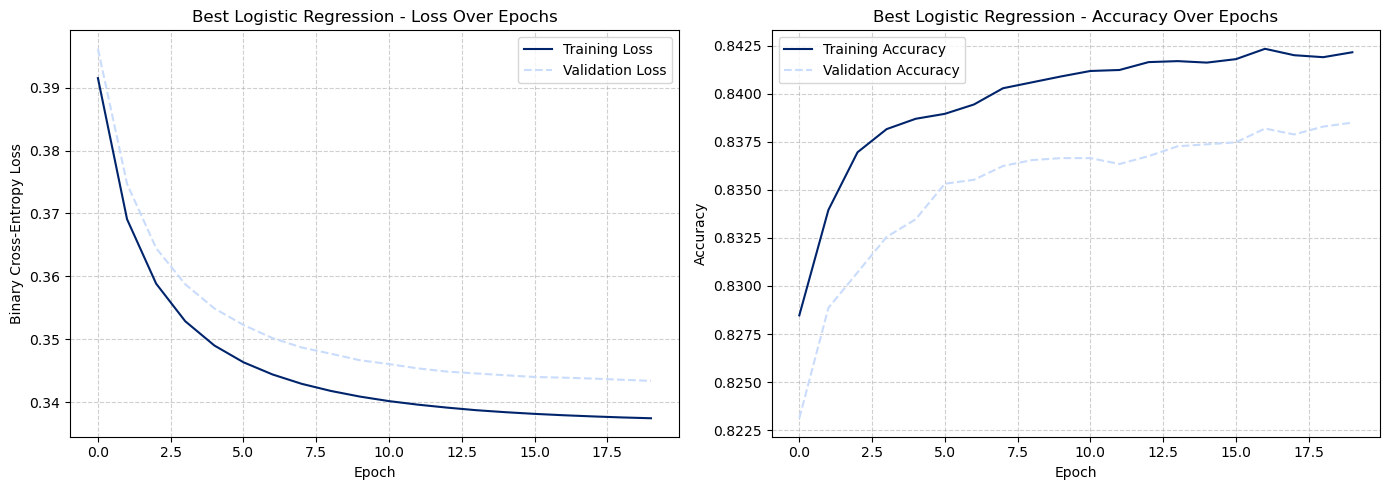

In [295]:
best_trainer = ModelTraining(
    model_class=LogisticRegression,
    model_name="Best Logistic Regression",
    init_params={'w': best_model.w, 'b': best_model.b, 'optimizer': best_optimizer, 'penalty': best_penalty, 'lam': best_lam},
    metrics_dict=metrics_dict,
    num_epochs=int(best_epochs),
    batch_size=32,
    plot_cm=True
)
best_trainer.train(X_train_scaled, y_train, X_test_scaled, y_test)
# plot training metrics (accuracy and loss for train/test)
if model_to_train.history:
    plot_training_history(best_trainer.history, best_trainer.model_name)

## 6 Final Analysis

In [296]:
print("Weights after training:", best_trainer.model.w)
print("Bias after training:", best_trainer.model.b)

Weights after training: [ 0.38676567  0.50743081  0.25645266  0.33390859  2.10676809  0.7081049
  0.47380458  0.09247737 -0.29594853 -0.03094195 -0.24002224 -0.16207314
 -0.30250216 -0.19776085]
Bias after training: -2.7491014438366244


In [297]:
# analyze coefficients
coefs = best_trainer.model.w
feature_names = [col for col in train_df_encoded.columns if col != 'income']
coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefs})
# 10 most important features
top_pos = coef_df.sort_values(by='coefficient', ascending=False).head(5)
top_neg = coef_df.sort_values(by='coefficient').head(5)
print("Top 5 Positive Coefficients (features that increase prob of >50K):")
print(top_pos)
print("\nTop 5 Negative Coefficients (features that decrease prob of >50K):")
print(top_neg)

Top 5 Positive Coefficients (features that increase prob of >50K):
             feature  coefficient
4         is_married     2.106768
5  education_ordinal     0.708105
1       capital-gain     0.507431
6  occupation_target     0.473805
0                age     0.386766

Top 5 Negative Coefficients (features that decrease prob of >50K):
                        feature  coefficient
12                   sex_Female    -0.302502
8   relationship_Other-relative    -0.295949
10                   race_Black    -0.240022
13                is_from_us_No    -0.197761
11                   race_Other    -0.162073


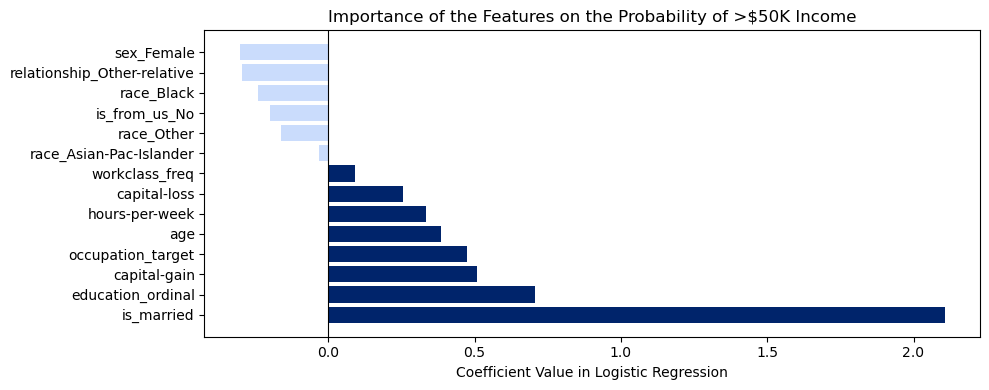

In [298]:
# plot the importance of all features for our best model, sorted by absolute value
coef_df_sorted = coef_df.reindex(coef_df['coefficient'].sort_values(ascending=False).index)
plt.figure(figsize=(10, 4))
plt.barh(coef_df_sorted['feature'], coef_df_sorted['coefficient'], color=['#00246B' if c > 0 else '#CADCFC' for c in coef_df_sorted['coefficient']])
plt.xlabel('Coefficient Value in Logistic Regression')
plt.title('Importance of the Features on the Probability of >$50K Income')
plt.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

### Interpreting Odds Ratios for Logistic Regression Coefficients

This shows the **odds ratios** for each feature in the logistic regression model. The odds ratio is calculated as `exp(coefficient)` and represents the multiplicative change in the odds of earning >$50K for a one-unit increase in the feature, holding all other features constant:

- **Odds Ratio > 1:** The feature increases the odds of high income. For example, an odds ratio of 2 means the odds double for each unit increase.
- **Odds Ratio < 1:** The feature decreases the odds of high income. For example, an odds ratio of 0.5 means the odds are halved for each unit increase.
- **Odds Ratio ≈ 1:** The feature has little or no effect on the odds.

#### What is a "unit increase" for each feature?

- **Standardized numerical features**: unit increase means **one standard deviation above the mean** of that feature .
  - For `capital-gain` and `capital-loss`, this is after a `log1p` transformation, so it reflects a standard deviation in the log-transformed value.

- **Binary features**: changing from 0 to 1 (e.g., from not married to married).

- **One-hot encoded features**: unit increase means belonging to that category versus the baseline (reference) category.

- **Ordinally encoded features**: unit increase means moving up by one level in the encoded order, but after standardization, it is also in units of standard deviation.

In [299]:
# Odds ratios for the features
coef_df["odds_ratio"] = np.exp(coef_df["coefficient"])
print("All features with their odds ratios:")
display(coef_df.loc[coef_df.index][["feature", "coefficient", "odds_ratio"]])

All features with their odds ratios:


,feature,coefficient,odds_ratio
0,age,0.386766,1.472211
1,capital-gain,0.507431,1.661018
2,capital-loss,0.256453,1.292338
3,hours-per-week,0.333909,1.396415
4,is_married,2.106768,8.221627
5,education_ordinal,0.708105,2.030140
6,occupation_target,0.473805,1.606093
7,workclass_freq,0.092477,1.096888
8,relationship_Other-relative,-0.295949,0.743826
9,race_Asian-Pac-Islander,-0.030942,0.969532
